# Superlevel set filtration with stitching to Vietoris-Rips-type filtration

This notebook takes in an image and generates a collection of output images, one for each threshold value of the original filtration. Each output image is the original image down to some threshold 0 <= k <= 255, and then below that, concentric rings of values less than k act as balls that grow outward from the superlevel set at threshold k. 

In [ ]:
import PersistenceExplorer as PE
import os
from scipy import misc
from skimage import morphology as morph
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

## Set up test directory with an initial image to process

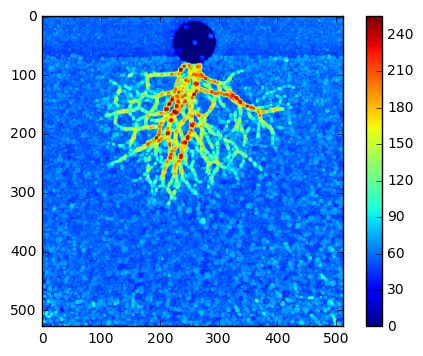

255


In [2]:
idx = 340

sbmp = '../data/granular_media/%06d.bmp' % idx
stmp = '../data/tmp/'

# Read in the image, take its negative, and dilate to 'blur' the force chains.
bmp = misc.imread(sbmp)
bmp = 255 - bmp
bmp = morph.dilation(bmp, morph.disk(2.5))*(255./np.max(bmp))
bmp = bmp.astype(np.int)

plt.imshow(bmp);
plt.colorbar();
plt.show()

print np.max(bmp)

In [3]:
os.mkdir(stmp)
os.mkdir(stmp + 'bmp')

misc.imsave(stmp + ('bmp/%06d_0.bmp' % idx), bmp)

## Process the superlevel set persistence diagram for this image

In [4]:
os.mkdir(stmp + 'pd_sup')
PE.ProcessImageListWithPHAT([stmp + ('bmp/%06d_0.bmp' % idx)], [stmp + ('pd_sup/%06d_0.csv' % idx)], 'super')

### Display original image and superlevel set persistence diagram.

In [5]:
imagefiles = [stmp + ('bmp/%06d_0.bmp' % idx)]
pdfiles = [stmp + ('pd_sup/%06d_0.csv' % idx)]
frames = [0]
imagesize = [512, 528]
max_image_display_size = 400
persistence_diagram_display_size = 400

In [6]:
dimension_of_interest = 1
PE.PersistenceExplorer(imagefiles, pdfiles, frames, dimension_of_interest, 
                    imagesize, max_image_display_size, persistence_diagram_display_size)

## Generate Vietoris-Rips-like variants of the original image

In [7]:
# Compute filtration step range by taking min/max of birth times of H1 generators
pd_sup = pd.read_csv(stmp + ('pd_sup/%06d_0.csv' % idx))

min_birth = min(pd_sup.loc[pd_sup['dim']==1]['birth'])
max_birth = max(pd_sup.loc[pd_sup['dim']==1]['birth'])


In [8]:
num_steps = 20  # Number of steps from first to last birth value (number of images in time series)
height_skip = 2 # Value of each level in Vietoris-Rips-type filtration
radius = 3      # Radius of expansion for Vietoris-Rips-type filtration

for step in range(0,num_steps):
    
    # Compute the initial threshold for this step
    threshold = max_birth - int(((max_birth - min_birth)/float(num_steps-1))*float(step))
    
    # Initialize the output image
    bmp_out = bmp.copy()
    bmp_out[bmp < threshold] = 0
    
    # Initialize union of prior binary matrices
    sum_of_binaries = np.zeros(bmp.shape)
    
    # Initialize initial superlevel set binary image at threshold
    dilated_superlevel = {}
    dilated_superlevel[-1] = (bmp >= threshold).astype(np.int)
    
    # Starting from (threshold-height_skip) going down by height_skip to zero
    rge_thresholds = range(threshold - height_skip, 0, -1*height_skip)
    for k in range(len(rge_thresholds)):
        
        # Inflate previous binary matrix minus sum of prior by radius
        dilated_superlevel[k] = np.multiply(morph.dilation(dilated_superlevel[k - 1], morph.disk(radius)), 1-sum_of_binaries)
        dilated_superlevel[k] = np.multiply(dilated_superlevel[k], 1-dilated_superlevel[k - 1])
        
        # Add new height value to bmp_out for this new inflated set
        bmp_out = bmp_out + dilated_superlevel[k]*rge_thresholds[k]

        # Add current binary matrix to prior sum
        sum_of_binaries = (sum_of_binaries.astype(np.bool) | dilated_superlevel[k - 1].astype(np.bool)).astype(np.int)
        
    misc.imsave(stmp + ('bmp/%06d_%d.bmp' % (idx, step+1)), bmp_out)



## Generate their persistence diagrams and explore them!

In [9]:
image_list = [stmp + ('bmp/%06d_%d.bmp' % (idx, step+1)) for step in range(0,num_steps)]
pd_list = [stmp + ('pd_sup/%06d_%d.csv' % (idx, step+1)) for step in range(0,num_steps)]

PE.ProcessImageListWithPHAT(image_list, pd_list, 'super')

In [10]:
frames = range(0,num_steps)
imagesize = [512, 528]
max_image_display_size = 400
persistence_diagram_display_size = 400

In [11]:
dimension_of_interest = 1
PE.PersistenceExplorer(image_list, pd_list, frames, dimension_of_interest, 
                    imagesize, max_image_display_size, persistence_diagram_display_size)